In [1]:
# Jul18_23-12-16 DCGAN
# Jul19_02-00-37 MLPGAN
# Jul19_09-12-50 Heavy Regularization + z loss
# Jul19_22_50_07 perfect encoding by fixing decoder


In [781]:
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.linalg import norm
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
import torch.distributions as td
from torch.utils.tensorboard import SummaryWriter


import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from utils import display, load_mnist, create_digit_grid

DATAPATH = Path.home() / '.datasets'

# load generator

In [555]:
# load pretrained generator

from gan_vae_pretrained.mnist_dcgan import dcgan
from gan_vae_pretrained.mnist_gan_mlp import gan_mnist

def load_generator_dcgan():
    latent_dim = 100
    generator = dcgan.Generator(ngpu=1).eval()
    state_dict = torch.load('gan_vae_pretrained/mnist_dcgan/weights/netG_epoch_99.pth',
                            map_location=torch.device('cpu'))
    generator.load_state_dict(state_dict)
    return generator, latent_dim


def load_generator_mlp():
    latent_dim = 64
    generator = gan_mnist.G
    state_dict = torch.load('gan_vae_pretrained/mnist_gan_mlp/weights/G--300.ckpt',
                            map_location=torch.device('cpu'))
    generator.load_state_dict(state_dict)
    return generator, latent_dim

torch.Size([92, 242])


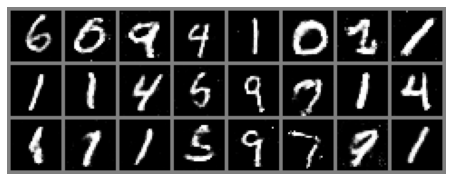

In [556]:
# plot generator samples
batch_size = 24

G, latent_size = load_generator_dcgan()
fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
fake_images = G(fixed_noise)


G, latent_size = load_generator_mlp()
fixed_noise = torch.randn(batch_size, latent_size)
fake_images = G(fixed_noise).reshape(-1, 1, 28, 28)

display(fake_images)

# train 

In [908]:
class Encoder(nn.Module):
    def __init__(self, in_size, out_dim, noise_size=0, return_dist=True):    
        super().__init__()
        self.noise_size = noise_size
        self.return_dist = return_dist
        
        self.layers = nn.Sequential(
            nn.Linear(in_size**2 + noise_size, 512), 
            nn.BatchNorm1d(512), nn.LeakyReLU(0.2), nn.Dropout(0.2),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512), nn.LeakyReLU(0.2), nn.Dropout(0.2),
            
            nn.Linear(512, (2 if return_dist else 1) * out_dim),
            )
    
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        n = torch.randn(size=(x.shape[0], self.noise_size))
        x_embed = torch.cat((x, n), dim=1)
        out = self.layers(x_embed)
        
        if self.return_dist:
            loc, log_scale = torch.tensor_split(out, 2, dim=-1)
            return td.Independent(
                td.Normal(
                    loc=loc,
                    scale=torch.exp(log_scale),
                ),
                reinterpreted_batch_ndims=1,
            )
        else:
            return out
        
        
    def sample_latent(self, x, add_dummy_dims=True):
        if self.return_dist:
            samples = self(x).rsample()
        else:
            samples = self(x)
        
        if add_dummy_dims:
            return samples[..., None, None]
        else:
            return samples
            


class Decoder(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        
        self.in_size = in_size
        self.out_size = out_size
        
        self.layer1 = nn.Sequential(
            nn.Linear(in_size**2, 256), 
            nn.BatchNorm1d(256), nn.LeakyReLU(0.1), 
            # nn.Dropout(0.1),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512), nn.LeakyReLU(0.1), 
            # nn.Dropout(0.1)
        )
        self.layer3 = nn.Linear(512, out_size**2)
        self.res_linear = nn.Linear(in_size**2, out_size**2)

        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        
        x_orig = x
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # x += self.res_linear(x_orig)
        x += x_orig
        
        # x = self.res_linear(x)
        
        x = torch.tanh(x)
        
        x = x.view(-1, 1, self.out_size, self.out_size)
        return x


In [909]:
x_size = 28
batch_size = 64
lr_enc = 0.0001
lr_dec = 0.0001
noise_size = 100
return_dist = True
weight_decay_enc = 1e-4
weight_decay_dec = 1e-8
z_decay = 1e-1
epochs = 20

In [910]:
mnist_lowres, _ = load_mnist(size=x_size)
x_loader = DataLoader(mnist_lowres, shuffle=True, batch_size=batch_size)
grid = create_digit_grid(mnist_lowres, cols=8)


generator, latent_size = load_generator_dcgan()
generator.requires_grad_(False)
add_dummy_dims = True

# generator, latent_size = load_generator_mlp()
# generator.requires_grad_(False)
# add_dummy_dims = False


encoder = Encoder(x_size, latent_size,
                  noise_size=noise_size, return_dist=return_dist)
decoder = Decoder(28, x_size)

# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.xavier_uniform_(m.weight, gain=0.01)
#         m.bias.data.fill_(0.01)
# encoder.apply(init_weights)


encoder.train()
decoder.train()


enc_optim = torch.optim.Adam(lr=lr_enc, 
                             params=encoder.parameters(),
                             weight_decay=weight_decay_enc)

dec_optim = torch.optim.Adam(lr=lr_dec,
                             params=decoder.parameters(),
                             weight_decay=weight_decay_dec)

z_norm2_prior = td.Chi2(latent_size)

In [912]:
# decoder = Decoder(28, x_size)
# dec_optim = torch.optim.Adam(lr=lr_dec,
#                              params=decoder.parameters(),
#                              weight_decay=weight_decay_dec)
# encoder.requires_grad_(False)

In [913]:
writer = SummaryWriter()
it = 0


for epoch in trange(epochs):
    for x, _ in tqdm(x_loader):
        z = encoder.sample_latent(x, add_dummy_dims)
        # z += torch.randn(z.shape) * 5
        y = generator(z).reshape(-1, 1, 28, 28)
        x_hat = decoder(y)
        # x_hat = F.interpolate(y, x_size)
        
        loss = (
            F.mse_loss(x, x_hat) 
            # + z_decay * torch.linalg.norm(z, dim=1).mean()
            # - z_decay * z_norm2_prior.log_prob(norm(z, dim=1).pow(2)).mean()
            + z_decay * (norm(z.mean(dim=0) - 0) + norm(z.var(dim=0) - 1))
            )
        
        enc_optim.zero_grad()
        dec_optim.zero_grad()
        loss.backward()
        enc_optim.step()
        dec_optim.step()
        
        if it % 25 == 1:
            with torch.no_grad():
                z = encoder.sample_latent(grid, add_dummy_dims)
                # z += torch.randn(z.shape) * 5
                y = generator(z).reshape(-1, 1, 28, 28)
                x_hat = decoder(y)
                # x_hat = F.interpolate(y, x_size)
                
                writer.add_scalar('Train Loss', loss, it)
                writer.add_images('images/x', grid, it)
                writer.add_images('images/x_hat', x_hat, it)
                writer.add_images('images/y', y, it)
                writer.add_histogram('w/enc_w1', encoder.layers[1].weight, it)
                writer.add_histogram('w/enc_w1_grad', encoder.layers[1].weight.grad, it)
        
        it += 1

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [ ]:
encoder.layers[1].weight.grad
# decoder.layers[1].weight.grad
# encoder.layers(x)

In [28]:
torch.linalg.norm(z.squeeze(), dim=-1).mean()
# torch.linalg.norm(torch.randn(size=(latent_size, )))


tensor(7.3786, grad_fn=<MeanBackward0>)

torch.Size([512, 325])

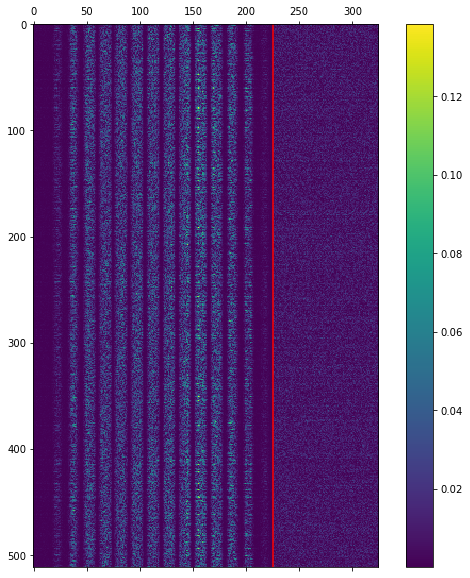

In [824]:
fig, ax = plt.subplots(figsize=(10, 10))
w = encoder.layers[0].weight.detach()
im = ax.matshow(w.abs())
plt.colorbar(im)
ax.axvline(x_size**2, color='r')
w.shape

torch.Size([302, 242])


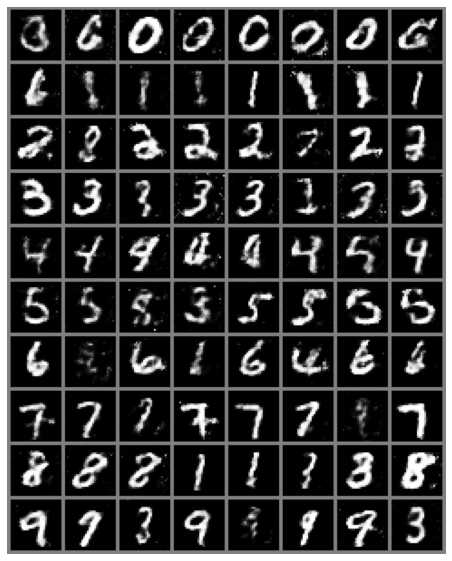

In [542]:
z = encoder.sample_latent(grid, add_dummy_dims)
z += torch.randn(z.shape) * .1
y = generator(z).reshape(-1, 1, 28, 28)
x_hat = decoder(y)

display(y)


In [901]:
# F.mse_loss(x, x_hat) 
# + z_decay * torch.linalg.norm(z, dim=1).mean()
# - z_decay * z_norm2_prior.log_prob(torch.linalg.norm(z, dim=1)).mean()
# x_hat.shape

# print(torch.linalg.norm(z, dim=1).mean())
# z_ = torch.randn(z.shape)
# print(torch.linalg.norm(z_, dim=1).mean())


print(z.mean(dim=0).mean(), z.var(dim=0).mean())

z_ = torch.randn(z.shape)
print(z_.mean(dim=0).mean(), z_.var(dim=0).mean())


tensor(0.0007, grad_fn=<MeanBackward0>) tensor(1.0215, grad_fn=<MeanBackward0>)
tensor(0.0318) tensor(0.9674)


In [902]:
z__.shape

torch.Size([32, 100])

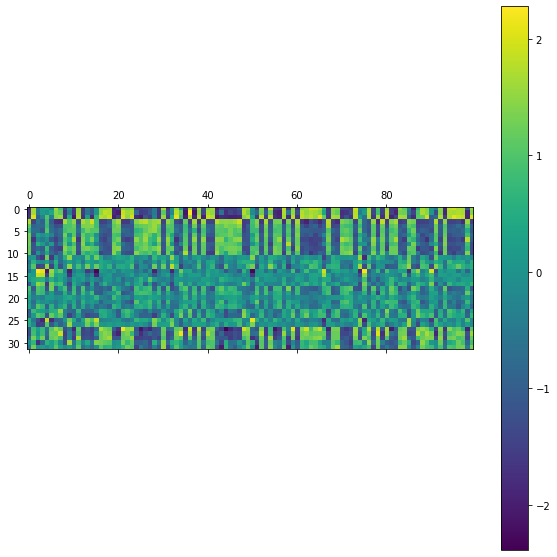

In [898]:
from sklearn.cluster import KMeans

n_clusters = 9
z_ = z.detach().cpu()[..., 0, 0]
kmeans = KMeans(n_clusters, random_state=0).fit(z_)
z__ = torch.cat([z_[kmeans.labels_ == i, :] for i in range(n_clusters)])
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.matshow(z__)
plt.colorbar(im)